# Image segmentation using fuzzy clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from time import time
import math
import random

%matplotlib inline

In [2]:
def change_color_fuzzycmeans(cluster_membership, clusters):
    
    img = []
    for pix in cluster_membership:
        img.append(clusters[np.argmax(pix)])
        
    return img

def change_color_kmeans(cluster_membership, clusters):
    
    img = []
    for pix in cluster_membership:
        img.append(clusters[int(pix[0])])
    
    return img

def readimage():
    folder = 'image-cancer/'
    list_images = os.listdir(folder)
    list_img = []
    for i in list_images:
        path = folder+i
        print(path)
        img = cv2.imread(path)
        rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
        list_img.append(rgb_img)
        
    return list_img


In [3]:
def euclidian_dist(x1, x2):
    d = len(x1)
    
    dist = 0
    
    for i in range(d):
        dist += pow((x1[i]-x2[i]),2)
    
    return dist

In [4]:
def fuzzy_c_means(data, n, k, d, p, maxiter):
    
    C = np.zeros((k,d))
    C_old = np.zeros((k,d))
    
    weight = np.random.dirichlet(np.ones(k),size=n)
    
    _iter = 0
    
    while _iter < maxiter:
        _iter += 1
        
        sum_weigth_pow = np.zeros(k)
        sum_weigth_pow_data = np.zeros((k,d))

        # Ovde imamo slozenost O(k*d*n)
        for i in range(k):
            for j in range(n):
                sum_weigth_pow[i] += pow(weight[j][i],p)
            for j in range(d):
                for r in range(n):
                    sum_weigth_pow_data[i][j] += pow(weight[r][i],p) * data[r][j]
            for j in range(d):
                C[i][j] = sum_weigth_pow_data[i][j] / sum_weigth_pow[i]

        ind = True
        
        for i in range(k):
            for j in range(d):
                if round(C_old[i][j],2) != round(C[i][j],2):
                    ind = False
                
        if ind:
            break
        
        for i in range(k):
            for j in range(d):
                C_old[i][j] = C[i][j]
        
        suma = np.zeros(n)
        
        for i in range(n):
            for j in range(k):
                suma[i] += pow((1/euclidian_dist(data[i], C[j])), 1/(p-1))
            for j in range(k):
                weight[i][j] = pow((1/euclidian_dist(data[i], C[j])), 1/(p-1)) / suma[i]
                
    return weight, C

In [5]:
def k_means(data, n, k, d, maxiter):
    
    C = np.zeros((k,d))
    C_old = np.zeros((k,d))
    data_clusters = np.zeros((n,1))
    
    for i in range(k):
        init_cntr = random.random()*255
        
        C[i] = [init_cntr, init_cntr, init_cntr]
    
    _iter = 0
    
    while _iter < maxiter:
        _iter += 1
        
        for i in range(n):
            
            min = float('inf')
            res_clust = 0
            
            index = 0
            for centroid in C:
                if euclidian_dist(data[i], centroid) < min:
                    min = euclidian_dist(data[i], centroid)
                    res_clust = index
                index += 1
            
            data_clusters[i] = res_clust
        
        for i in range(k):
            
            counter_elements = 0
            
            for j in range(n):
                if i == data_clusters[j]:
                    for k in range(d):
                        C[i][k] += data[j][k]
                    counter_elements += 1
                    
            if counter_elements != 0:
                for k in range(d):
                        C[i][k] /= counter_elements
        
        ind = True
        
        for i in range(k):
            for j in range(d):
                if round(C_old[i][j],2) != round(C[i][j],2):
                    ind = False
                
        if ind:
            break
        
        for i in range(k):
            for j in range(d):
                C_old[i][j] = C[i][j]
    
    return data_clusters, C

# K - means

Images:
image-cancer/tumor_2.png
image-cancer/braintumor.png
image-cancer/tumor_1.png

Image 1:
Time for 4 clusters:
15.01 seconds
Time for 5 clusters:
16.63 seconds
Time for 6 clusters:
16.95 seconds

Image 2:
Time for 4 clusters:
12.37 seconds
Time for 5 clusters:
30.82 seconds
Time for 6 clusters:
21.2 seconds

Image 3:
Time for 4 clusters:
30.34 seconds
Time for 5 clusters:
42.5 seconds
Time for 6 clusters:
27.29 seconds



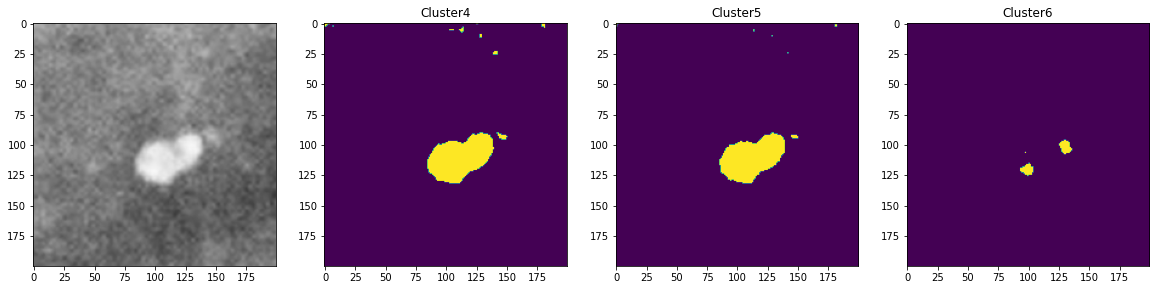

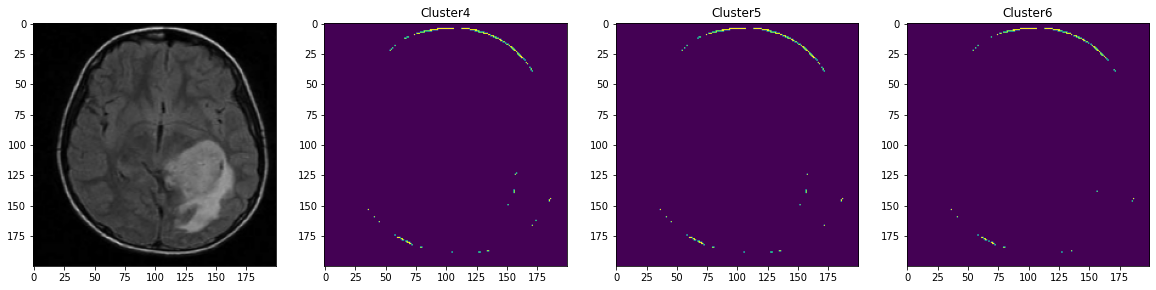

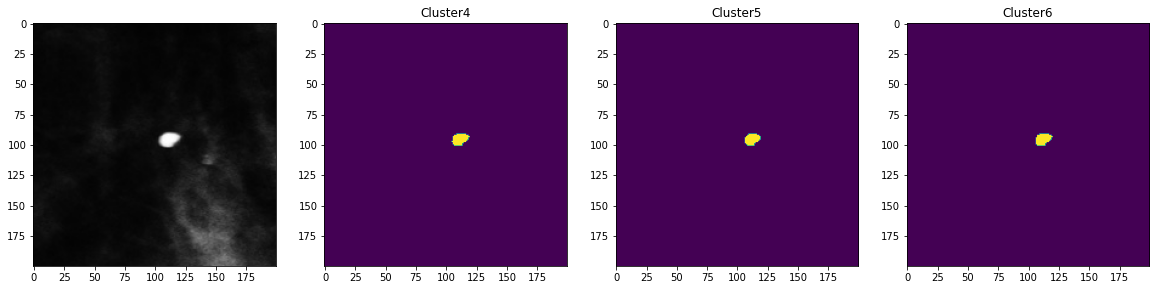

In [6]:
print("Images:")
list_img = readimage()
print()
clusters = [4,5,6]

for index,rgb_img in enumerate(list_img):
    
    img = np.reshape(rgb_img, (200,200,3)).astype(np.uint8)
    shape = np.shape(img)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    print('Image '+str(index+1) + ":")

    for i,cluster in enumerate(clusters):
            
        new_time = time()

        u_k, cntr_k = k_means(rgb_img, rgb_img.shape[0], cluster, 3, 100)
        
        print('Time for',cluster, "clusters:")
        print(round(time() - new_time, 2),'seconds')
        
        new_img = change_color_kmeans(u_k, cntr_k)
        
        fuzzy_img = np.reshape(new_img, shape).astype(np.uint8)
        
        ret, seg_img = cv2.threshold(fuzzy_img, np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
        
        seg_img_1d = seg_img[:,:,1]
        
        plt.subplot(1, 4, i+2)
        plt.imshow(seg_img_1d)
        name = 'Cluster'+str(cluster)
        plt.title(name)
    
    name = 'segmented_k_means'+str(index)+'.png'
    plt.savefig(name)
    print()

# Fuzzy c-means

Images:
image-cancer/tumor_2.png
image-cancer/braintumor.png
image-cancer/tumor_1.png

Image 1
Fuzzy time for 4 clusters:
217.56 seconds
Fuzzy time for 5 clusters:
286.42 seconds
Fuzzy time for 6 clusters:
485.07 seconds

Image 2
Fuzzy time for 4 clusters:
132.35 seconds
Fuzzy time for 5 clusters:
260.18 seconds
Fuzzy time for 6 clusters:
713.73 seconds

Image 3
Fuzzy time for 4 clusters:
476.12 seconds
Fuzzy time for 5 clusters:
471.1 seconds
Fuzzy time for 6 clusters:
705.6 seconds



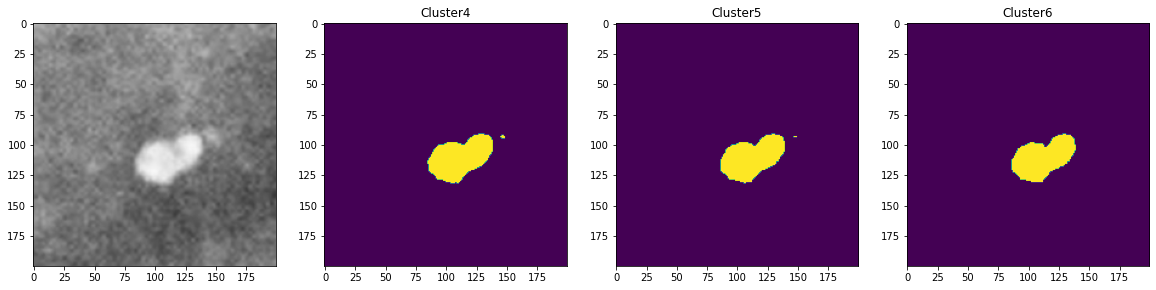

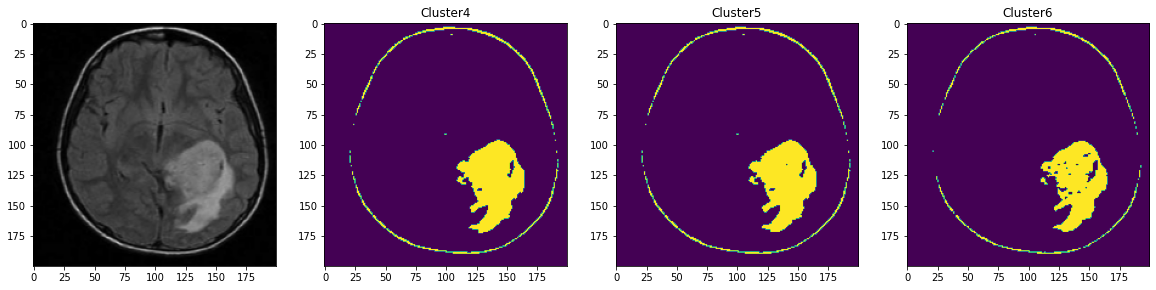

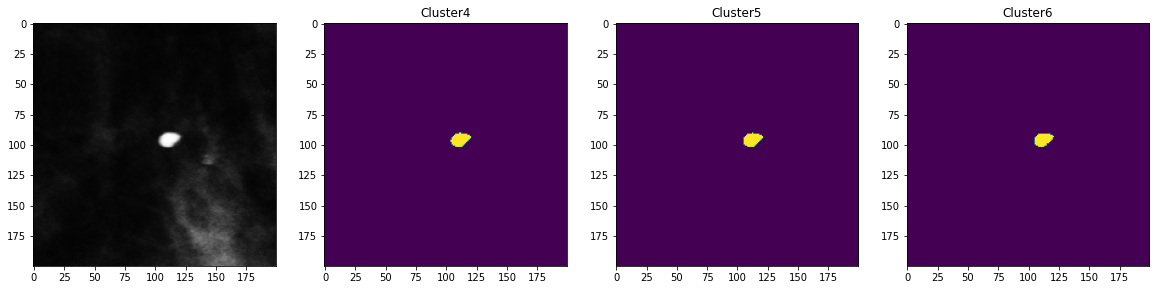

In [7]:
print("Images:")
list_img = readimage()
print()
clusters = [4,5,6]
        
for index,rgb_img in enumerate(list_img):
    
    img = np.reshape(rgb_img, (200,200,3)).astype(np.uint8)
    shape = np.shape(img)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    print('Image '+str(index+1))

    for i,cluster in enumerate(clusters):
            
        new_time = time()
            
        u, cntr = fuzzy_c_means(rgb_img, rgb_img.shape[0], cluster, 3, 2, 100)
        
        print('Fuzzy time for',cluster, "clusters:")
        print(round(time() - new_time, 2),'seconds')
    
        new_img = change_color_fuzzycmeans(u,cntr)
        
        fuzzy_img = np.reshape(new_img, shape).astype(np.uint8)
        
        ret, seg_img = cv2.threshold(fuzzy_img, np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
        
        seg_img_1d = seg_img[:,:,1]
        
        plt.subplot(1, 4, i+2)
        plt.imshow(seg_img_1d)
        name = 'Cluster'+str(cluster)
        plt.title(name)
        
    
    name = 'segmented'+str(index)+'.png'
    plt.savefig(name)
    print()